# Initial-EDA

In here I will try to determin the health of the data:

    - looking for missing entries

    - deciding how best to deal with them

    - looking for data types and formats that should be chaged

    - univariate analysis of the features

    - looking for Time Series Analysis (TSA) specific components

      - Trend
      - Seasonality
      - Cyclic
      - Irregularity

    - Identifying the Time Series Data type

      - Stationary or Non-Stationary
      - Using statistical tests to check if the data is Stationary
        1. Augmented Dickey-Fuller (ADF) Test
        2. Kwiatkowski-Plillips-Schmidt-Shin (KPSS) Test

    - Converting data to Stationary type
      - Detrending
      - Deferencing

# Imports

In [38]:
import sys
sys.path.append('../')

import random
from src.fetch_data import DataLoader
from src.exploration import Analysis
from src.cleaning import CleanDataFrame
from src.visualization import Plotters
from src.rotating_logs import get_rotating_log

# Store Data EDA

## Loading the data

In [2]:
data_path = 'data/raw/store.csv'
version = 'raw_data'
repo = '../'

store_df = DataLoader.dvc_get_data(data_path, version, repo)

DataLoaderLogger - INFO - DVC: CSV file read with path: data/raw/store.csv | version: raw_data | from: ../


Let's how the data looks like

In [3]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


## Missing values

In [5]:
analyzer = Analysis()
missing_with_count, cols_with_missing = analyzer.get_missing_entries_count(store_df)
missing_with_count

CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [6]:
promoted_store = store_df.query("Promo2==0")
promoted_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 0 to 1113
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      544 non-null    int64  
 1   StoreType                  544 non-null    object 
 2   Assortment                 544 non-null    object 
 3   CompetitionDistance        542 non-null    float64
 4   CompetitionOpenSinceMonth  396 non-null    float64
 5   CompetitionOpenSinceYear   396 non-null    float64
 6   Promo2                     544 non-null    int64  
 7   Promo2SinceWeek            0 non-null      float64
 8   Promo2SinceYear            0 non-null      float64
 9   PromoInterval              0 non-null      object 
dtypes: float64(5), int64(2), object(3)
memory usage: 46.8+ KB


The promo related missing values can be simply explained by the above print outs. All the stores that were not running a promo (`Promo2==0`), don't have any data for those columns. Since they are all measure, I think I can set the `Promo2SinceWeek` and `Promo2SinceYear` columns to zero's. And for the `PromoInterval`, I will set it to 'none'



In [7]:
cleaner = CleanDataFrame()
store_df = cleaner.replace_missing(df=store_df, 
                                columns=cols_with_missing[-3:-1], 
                                method='zero')
store_df = cleaner.replace_missing(df=store_df, 
                                columns=cols_with_missing[-1:], 
                                replace_with='none')

Now, let's look at the competition related missing values.

In [8]:
missing_with_count, cols_with_missing = analyzer.get_missing_entries_count(store_df)
missing_with_count

CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
dtype: int64

For most of the missing values, we have the `CompetitionDistance`. We just don't have the time they started competing with those stores. I think this is because we just don't have the data of when they started. 

Next, I will look at some of the rows from above with the missing entries

### Where `CompetitionDistance` is null

In [9]:
store_df[store_df["CompetitionDistance"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,0.0,0.0,none
621,622,a,c,NaN,NaN,NaN,0,0.0,0.0,none
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


### Where `CompetitionDistance` is not null but `CompetitionOpenSinceMonth` is null

In [10]:
store_df[(~store_df["CompetitionDistance"].isnull() & store_df["CompetitionOpenSinceMonth"].isnull())].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,0.0,0.0,none
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


### Where `CompetitionDistance` is not null but `CompetitionOpenSinceYear` is null

In [11]:
store_df[(~store_df["CompetitionDistance"].isnull() & store_df["CompetitionOpenSinceYear"].isnull())].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,0.0,0.0,none
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


The above two should be identical

In [12]:
store_df[(~store_df["CompetitionDistance"].isnull() & store_df["CompetitionOpenSinceMonth"].isnull())].head().equals(
    store_df[(~store_df["CompetitionDistance"].isnull() & store_df["CompetitionOpenSinceYear"].isnull())].head())

True

### Filling `CompetitionDistance` and `CompetitionOpenSinceYear`

Since some of the rows have year they started promotion, I will use that instead of leaving them empity. But firts I will need to fill the `CompetitionDistance`.
I will first check it's skewnees and decide on a method for it.

In [13]:
analyzer.get_univariate_analysis(store_df)

,count,mean,std,min,25%,50%,75%,max,mode,CoV,skew,kurtosis,iqr,missing_counts
Store,1115.0,558.000000,322.017080,1.0,279.5,558.0,836.5,1115.0,1.0,0.577092,0.000000,-1.200000,557.0,0
CompetitionDistance,1112.0,5404.901079,7663.174720,20.0,717.5,2325.0,6882.5,75860.0,250.0,1.417820,2.929286,13.097514,6165.0,3
CompetitionOpenSinceMonth,761.0,7.224704,3.212348,1.0,4.0,8.0,10.0,12.0,9.0,0.444634,-0.170750,-1.242506,6.0,354
CompetitionOpenSinceYear,761.0,2008.668857,6.195983,1900.0,2006.0,2010.0,2013.0,2015.0,2013.0,0.003085,-8.013062,128.218693,7.0,354
Promo2,1115.0,0.512108,0.500078,0.0,0.0,1.0,1.0,1.0,1.0,0.976509,-0.048510,-2.001240,1.0,0
Promo2SinceWeek,1115.0,12.083408,15.542241,0.0,0.0,1.0,22.0,50.0,0.0,1.286246,0.950294,-0.619449,22.0,0
Promo2SinceYear,1115.0,1030.239462,1006.038782,0.0,0.0,2009.0,2012.0,2015.0,0.0,0.976510,-0.048506,-2.001234,2012.0,0


<AxesSubplot:>

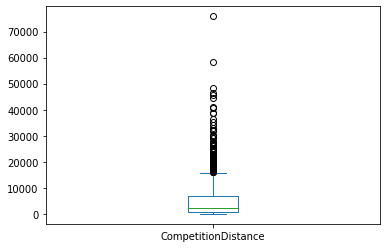

In [14]:
store_df['CompetitionDistance'].plot.box()

It is skewed and has alot of outliers. I will use meadial to fill it.

In [15]:
store_df = cleaner.replace_missing(store_df, ['CompetitionDistance'], method='median')
missing_with_count, cols_with_missing = analyzer.get_missing_entries_count(store_df)
missing_with_count

CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
dtype: int64

In [17]:
missing_comp = store_df['CompetitionOpenSinceYear'].isnull().values
store_df.loc[missing_comp, 'CompetitionOpenSinceYear'] = store_df.loc[missing_comp, 'Promo2SinceYear']
missing_with_count, cols_with_missing = analyzer.get_missing_entries_count(store_df)
missing_with_count

CompetitionOpenSinceMonth    354
dtype: int64

Now that we have done that, the only column with a missing value is the `CompetitionOpenSinceMonth` column. I will just set that to a randomly selected month for each row.

In [24]:
store_df['CompetitionOpenSinceMonth'].fillna(random.choice(store_df['Promo2SinceYear'].notna()), inplace=True)
analyzer.percent_missing(store_df)

The dataset contains 0.0 % missing values.


In [25]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,none
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,none


We have taken care of the missing entries

## Data Types

In [26]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   object 
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 87.2+ KB


In [27]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,none
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,none


The datatypes for all the columns seems okay for now. There are some categoricals like Store and StoreType that are string. But I will leave it like that for now.

## Univariate Analysis

## Categorical columns unique count

In [28]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,none
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,none


In [34]:
print(f"There are {store_df['Store'].unique().shape[0]} unique stores")

There are 1115 unique stores


There are 4 unique store types


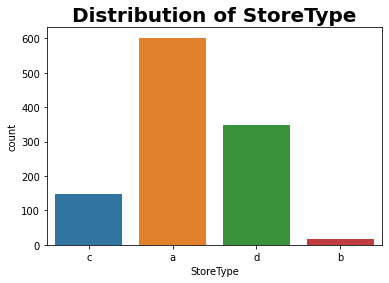

In [69]:
print(f"There are {store_df['StoreType'].unique().shape[0]} unique store types")
plotters.plot_count(store_df, 'StoreType')

There are 3 unique store types


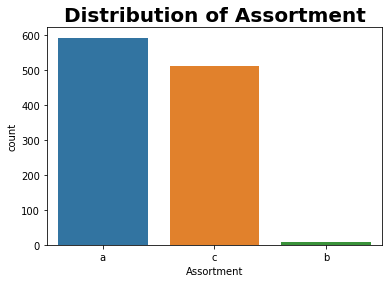

In [68]:
print(f"There are {store_df['Assortment'].unique().shape[0]} unique store types")
plotters.plot_count(store_df, 'Assortment')

There are 4 unique store types


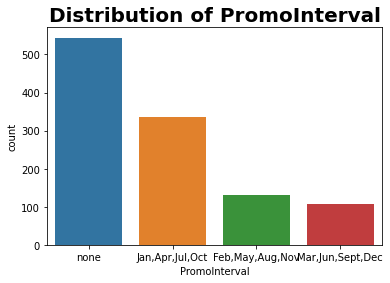

In [67]:
print(f"There are {store_df['PromoInterval'].unique().shape[0]} unique store types")
plotters.plot_count(store_df, 'PromoInterval')

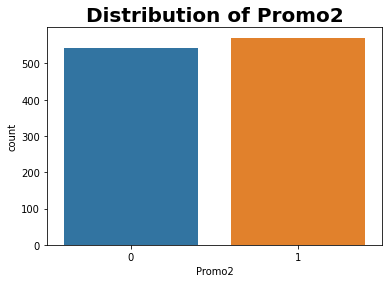

In [66]:
# store_df['Promo2'].value_counts().plot.pie()
plotters.plot_count(store_df, 'Promo2')

In [70]:
# plotters.plot_scatter(store_df, x_col='Store', y_col='CompetitionDistance', title='Stores vs CompetitionDistance', hue='CompetitionDistance', style='Assortment')